In [1]:
import torch
import torch.nn as nn

In [2]:
class Discriminator(nn.Module):
    def __init__(self, channel_count, feature_d):
        """

        :param channel_count: how many color channels are there in the image
        :param feature_d:
        """
        super(Discriminator, self).__init__()

        self.network = nn.Sequential(
            # Input: N x channel_count x 64 x 64
            nn.Conv2d(
                channel_count, feature_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            self.block(feature_d, feature_d * 2),  # 16x16
            self.block(feature_d * 2, feature_d * 4),  #8x8
            self.block(feature_d * 4, feature_d * 8),  #4x4

            nn.Conv2d(feature_d * 8, 1, kernel_size=4, stride=2, padding=0),  # 1x1
            nn.Sigmoid()
        )

    @staticmethod
    def block(in_channels: int, out_channels: int,
              kernel_size: int = 4, stride: int = 2, padding: int = 1) -> nn.Sequential:
        """
        Get a building block of Discriminator
        :param in_channels:
        :param out_channels:
        :param kernel_size:
        :param stride:
        :param padding:
        :return:
        """
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x) -> torch.Tensor:
        return self.network(x)



In [3]:
class Generator(nn.Module):
    def __init__(self, noise_size, channel_count, features_g):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            self.block(noise_size, features_g * 16, stride=1, padding=0),  # N x f_g x 16 x 4 x 4
            self.block(features_g * 16, features_g * 8),  # 8x8
            self.block(features_g * 8, features_g * 4),  # 16x16
            self.block(features_g * 4, features_g * 2),  # 32x32

            nn.ConvTranspose2d(
                features_g * 2,
                channel_count,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.Tanh()  # -1 to 1
        )

    @staticmethod
    def block(in_channels: int, out_channels: int,
              kernel_size: int = 4, stride: int = 2, padding: int = 1) -> nn.Sequential:
        """
        Get a building block of Generator
        :param in_channels:
        :param out_channels:
        :param kernel_size:
        :param stride:
        :param padding:
        :return:
        """
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    def forward(self, x) -> torch.Tensor:
        return self.network(x)


In [4]:
def initialize_weight(model):
    for m in model.modules():
        if isinstance(m, (
                nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d
        )):
            nn.init.normal_(m.weight.data, 0.0, 0.002)



In [5]:
def test():
    n = 8
    channel_count = 3
    h = 64
    w = 64

    noise_dim = 100
    x = torch.rand((n, channel_count, h, w))

    disc = Discriminator(channel_count, 8)
    initialize_weight(disc)

    # print(disc(x).shape)

    assert  disc(x).shape == (n, 1, 1, 1)

    gen = Generator(noise_dim, channel_count, 8)
    z = torch.randn((n, noise_dim, 1, 1))
    initialize_weight(gen)
    assert gen(z).shape == (n, channel_count, h, w)

    print("success")

# test()

In [6]:
from math import trunc

In [7]:

import torchvision.transforms.functional as TF
class RalativeRandomCrop(nn.Module):
    def __init__(self, rela_size):
        if rela_size>1 or rela_size<0:
            raise ValueError("rela_size must be in [0,1]")
        self.rela_size = rela_size

    def foeward(self, x):
        return self.__call__(x)

    def __call__(self, x):
        w, h = TF.get_image_size(x)
        small_side = min(w, h)
        new_size = int(small_side * self.rela_size)
        # print(f"img w: {w}, img h: {h}, new size: {new_size}")
        
        i = torch.randint(low=0,high=w - new_size,size=(1,)).item()
        j = torch.randint(low=0,high=h - new_size,size=(1,)).item()
        return TF.crop(x, i, j, new_size, new_size)
        # return TF.crop(x, top, left, new_h, new_w)

# t = RalativeRandomCrop(0.5)
# t(torch.rand(3, 64, 64))


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rate = 0.0002
batch_size = 128
image_size = 64

channel_count = 1

noise_dim = 100
features_discriminator = 64
features_generate = 64

In [9]:
import torchvision
import torchvision.transforms as transforms

transforms = transforms.Compose([
    # transforms.RandomCrop(image_size * 4),
    RalativeRandomCrop(0.9),
    transforms.Resize(image_size),
    # transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.5 for _ in range(channel_count)], [0.5 for _ in range(channel_count)]
    )
])


In [10]:
# import DataLoader
from torch.utils.data import DataLoader
import torchvision.datasets as datasets

import torch.utils.data as data
dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)
# dataset = datasets.ImageFolder(root="dataset/Thumbnails", transform=transforms)



loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


print(f"channel count: {channel_count}")


channel count: 1


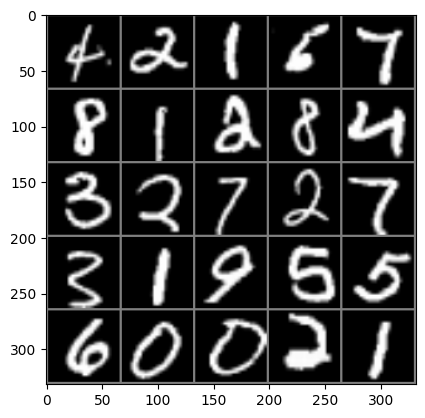

In [11]:
import matplotlib.pyplot as plt
# takes a batch of images and plots them in a grid
def show_tensor_images(image_tensor, num_images=25, size=(1, 64, 64)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = torchvision.utils.make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0)*0.5 + 0.5)
    plt.show()

show_tensor_images(next(iter(loader))[0], size=(channel_count, image_size, image_size))
# loader.dataset[1]


In [12]:

# import SummaryWriter
from torch.utils.tensorboard import SummaryWriter


gen = Generator(noise_dim, channel_count, features_generate).to(device)
initialize_weight(gen)
gen.train()
disc = Discriminator(channel_count, features_discriminator).to(device)
initialize_weight(disc)
disc.train()

generator_optimizer = torch.optim.Adam(gen.parameters(), lr=learning_rate, betas=(0.5, 0.999))

discriminator_optimizer = torch.optim.Adam(disc.parameters(), lr=learning_rate, betas=(0.5, 0.999))

criterion = nn.BCELoss()

fixed_noise = torch.randn(32, noise_dim, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")


In [13]:
step = 0


In [14]:
def train(gen:Generator, disc:Discriminator, num_epochs = 1):
    global step

    for epoch in range(num_epochs):
        
        for batch_idx, (real, _) in enumerate(loader):
            print(f"epoch: {epoch}, step: {step}, batch idx: {batch_idx}", end="\r")
            real = real.to(device)

            noise = torch.randn(batch_size, noise_dim, 1, 1).to(device)
            fake = gen(noise)

            # Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
            disc_real = disc(real).reshape(-1)
            loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))

            disc_fake = disc(fake).reshape(-1)
            loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
            loss_disc = (loss_disc_real + loss_disc_fake) / 2
            disc.zero_grad()
            loss_disc.backward(retain_graph=True)
            discriminator_optimizer.step()
            # Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
            output = disc(fake).reshape(-1)
            loss_gen = criterion(output, torch.ones_like(output))
            gen.zero_grad()
            loss_gen.backward()
            generator_optimizer.step()



            if batch_idx % 200 == 0:
                print(
                    f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                      Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
                )

                with torch.no_grad():
                    fake = gen(fixed_noise)
                    img_grid_real = torchvision.utils.make_grid(
                        real[:32], normalize=True
                    )
                    img_grid_fake = torchvision.utils.make_grid(
                        fake[:32], normalize=True
                    )

                    writer_real.add_image("Real Images", img_grid_real, global_step=step)
                    writer_fake.add_image("Fake Images", img_grid_fake, global_step=step)
                    print(f"step: {step}")
                    step += 1

In [15]:
# train(gen, disc, num_epochs=800)

In [16]:
# train(gen, disc, num_epochs=1000)

In [17]:
# train(gen, disc, num_epochs=3000)

In [18]:
train(gen, disc, num_epochs=5)

Epoch [0/5] Batch 0/469                       Loss D: 0.6932, loss G: 0.6886
step: 0
Epoch [0/5] Batch 200/469                       Loss D: 0.0142, loss G: 4.2301
step: 1
Epoch [0/5] Batch 400/469                       Loss D: 0.4915, loss G: 1.2673
step: 2
Epoch [1/5] Batch 0/469                       Loss D: 0.5199, loss G: 1.6838
step: 3
Epoch [1/5] Batch 200/469                       Loss D: 0.6380, loss G: 0.7403
step: 4
Epoch [1/5] Batch 400/469                       Loss D: 0.6667, loss G: 0.8205
step: 5
Epoch [2/5] Batch 0/469                       Loss D: 0.6908, loss G: 0.7385
step: 6
Epoch [2/5] Batch 200/469                       Loss D: 0.6588, loss G: 0.7765
step: 7
Epoch [2/5] Batch 400/469                       Loss D: 0.6661, loss G: 0.3812
step: 8
Epoch [3/5] Batch 0/469                       Loss D: 0.6628, loss G: 0.8227
step: 9
Epoch [3/5] Batch 200/469                       Loss D: 0.6308, loss G: 1.0409
step: 10
Epoch [3/5] Batch 400/469                       Lo

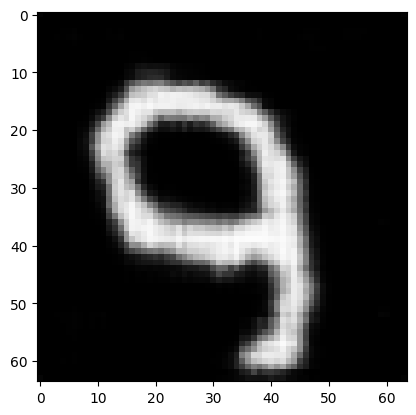

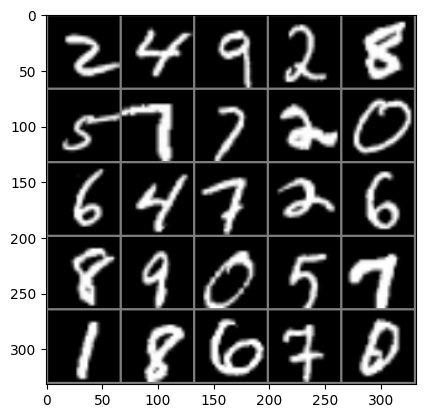

In [19]:
real = next(iter(loader))[0]
show_tensor_images(gen(fixed_noise)[10], size=(channel_count, image_size, image_size), num_images=1)
show_tensor_images(real, size=(channel_count, image_size, image_size))

In [20]:
from torchvision.utils import save_image
for i in range(32):
    save_image(gen(fixed_noise)[i] * 0.5 + 0.5, f"generated{i}.png")